## Hierarchical Team Agents

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import os
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

In [4]:
result = llm.invoke("What is the capital of France?")

In [5]:
result

AIMessage(content='The capital of France is Paris.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 14, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-Bp71PGeKqyiECDXFWVKMlKBeNdNVf', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--60120b88-e802-4d19-bcb4-91a98877afe5-0', usage_metadata={'input_tokens': 14, 'output_tokens': 7, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [6]:
result.content

'The capital of France is Paris.'

## Creating Tools


In [7]:
from typing import List,Annotated

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

USER_AGENT environment variable not set, consider setting it to identify your requests.


### Research Team Tools


- Tool1 : tavily search
- Tool2 : web loader


In [8]:
# Tool1 : tavily search
search_tool=TavilySearchResults(max_results=5)

# Tool2 : web loader
# this tool is used to scrape the web pages for detailed information and store it in a single document
@tool
def scrape_webpage(url:List[str]):
    """ Use requests and bs4 to scrape the provided web pages for detailed information"""
    loader=WebBaseLoader(web_paths=url)
    docs=loader.load()
    return "\n\n".join([
        f'<Document name="{doc.metadata.get("title","")}">\n {doc.page_content}\n</Document>' for doc in docs
    
    ])




In [9]:
search_tool.invoke("What is the capital of France?")

[{'title': 'What are the three official capitals of France and which one ... - Quora',
  'url': 'https://www.quora.com/What-are-the-three-official-capitals-of-France-and-which-one-is-the-most-commonly-visited',
  'content': "What is the capital of France? What are some of its major cities?\n\nThe capital of France is Paris. It is not only the country's capital but also its largest city and a global center for art, culture, fashion, and cuisine. Paris is home to iconic landmarks such as the Eiffel Tower, Louvre Museum, Notre-Dame Cathedral, and the Champs-Élysées. [...] The capital of France is Paris. It is not only the country's capital but also its largest city and a global center for art, culture, fashion, and cuisine. Paris is home to iconic landmarks such as the Eiffel Tower, Louvre Museum, Notre-Dame Cathedral, and the Champs-Élysées.\n\nApart from Paris, France has several other major cities that are significant in terms of population, economy, history, and cultural importance. S

In [10]:
# Correct usage: pass a list of URLs directly, not a dict
page_urls = ["https://medium.com/@tejpal.abhyuday/retrieval-augmented-generation-rag-from-basics-to-advanced-a2b068fd576c"]

scrape_webpage.invoke({"url": page_urls})



'<Document name="Retrieval-Augmented Generation (RAG) from basics to advanced | by Tejpal Kumawat | Medium">\n Retrieval-Augmented Generation (RAG) from basics to advanced | by Tejpal Kumawat | MediumSitemapOpen in appSign upSign inMedium LogoWriteSign upSign inRetrieval-Augmented Generation (RAG) from basics to advancedTejpal Kumawat12 min read·Feb 14, 2024--4ListenShareIntroduction:Retrieval-Augmented Generation (RAG) is a technique that enhances language model generation by incorporating external knowledge.This is typically done by retrieving relevant information from a large corpus of documents and using that information to inform the generation process.Challenge:Clients often have vast proprietary documents.Extracting specific information is like finding a needle in a haystack.2. GPT4-Turbo Introduction:OpenAI’s GPT4-Turbo can process large documents.3. Efficiency Issue:“Lost In The Middle” phenomenon hampers efficiency.Model forgets content in the middle of its contextual window.

### Document Team Tools


- tool1: create_outline
- tool2: read_document
- tool3: write_document
- tool4: edit_document
- tool5: python_repl_tool : to execute python codes

In [11]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import List,Annotated,Dict,Optional
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict


In [12]:
_TEMP_DIR = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIR.name)

In [13]:
# a temporary directory is created to store the documents
WORKING_DIRECTORY


WindowsPath('C:/Users/AKASHS~1/AppData/Local/Temp/tmpfbf2qq7e')

In [16]:
#tool1: create_outline
@tool
def create_outline(points:Annotated[List[str],"List of main points or sections"]
                   ,file_name:Annotated[str,"File path to save the outline"]) -> Annotated[str,"File path to the created outline"]:
    
    """
    Create an outline for a document based on the points in documnent and save it to the working directory
    """

    file_path=WORKING_DIRECTORY/f"{file_name}.txt"
    with open(file_path,"w") as f:
        for i, point in enumerate(points,start=0):
            f.write(f"{i+1}. {point}\n")
    return f"Outline created and saved to {file_path}"





In [17]:
# tool2: read_document

@tool
def read_document(
    file_name: Annotated[str,"File path to read the document from"],
    start: Annotated[Optional[int],"The start line. Default line starts from 0"] = None,
    end: Annotated[Optional[int],"The end line. Default line is 0"]=None
)->str:
    """
    Read the specified document which was saved in working directory
    """
    file_path=WORKING_DIRECTORY/f"{file_name}.txt"
    with open(file_path,"r") as f:
        lines = f.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])

In [18]:
# tool3: write_document

@tool
def write_document(content: Annotated[str, "Text content to be written into the document"],
                   file_name: Annotated[str, "File path to save the document"]) -> Annotated[str,"Path of the saved document file"]:
    
    """
    create and save text document

    """
    with open(WORKING_DIRECTORY/{file_name},"w") as f:
        f.write(content)
    return f"Document saved to {file_name}"
    

In [19]:
# tool4: edit_document

@tool
def edit_document(file_name: Annotated[str, "path of the document to be edited"],
                  inserts: Annotated[
                            dict[int,str],
                            "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at the line number"
                                     ]) -> Annotated[str, "Path of the edited document file"]:
    
    "Edit the document by inserting text at specific line number"
    with open(WORKING_DIRECTORY/{file_name},"r") as f:
        lines = f.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1<=line_number<=len(lines)+1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is our to range"
        
    with open(WORKING_DIRECTORY/{file_name},"w") as f:
        f.writelines(lines)

    return f"Documenet edited and saved to {file_name}"
            


In [20]:
repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    return f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"

    

## Helper Utilities

In [24]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel
from langgraph.graph import StateGraph, MessagesState,START,END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages


class State(MessagesState):
    next:str

def make_supervisor_node(llm:BaseChatModel, members: list[str]) -> str:

    options = ["FINISH"] + members

    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        "Worker to rout to next. If no workers needed, rout to FINISH"
        next: Literal[*options]

    def supervisor_node(state:State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""

        messages = [{"role":"system", 
                     "content":system_prompt}] + state["messages"]
        
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]

        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next":goto})
    
    return supervisor_node

## Defining Agents


### Research Team

In [25]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o")



In [26]:
search_agent = create_react_agent(llm, tools=[search_tool])

def search_node(state:State) -> Command[Literal["supervisor"]]:

    result = search_agent.invoke(state)

    return Command( 
        update={"messages":[
            HumanMessage(content=result["messages"][-1].content, name = "search")
        ]},
        goto="supervisor"
    )

In [27]:
web_scraper_agent = create_react_agent(llm, tools=[scrape_webpage])

def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)

    return Command(
        update={"messages": [
            HumanMessage(content=result["messages"][-1].content, name="web_scraper")
        ]},
        goto="supervisor"


    )

In [28]:
research_supervisor_node = make_supervisor_node(llm,["search","web_scraper"])

In [29]:
research_builder = StateGraph(State)

research_builder.add_node("supervisor",research_supervisor_node)
research_builder.add_node("search",search_node)
research_builder.add_node("web_scraper",web_scraper_node)

research_builder.add_edge(START,"supervisor")
research_graph = research_builder.compile()

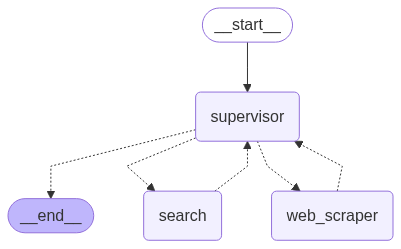

In [30]:
from IPython.display import display,Image
display(Image(research_graph.get_graph().draw_mermaid_png()))

In [46]:
for s in research_graph.stream(
    {"messages":[("user","what is Rag? provide some references")]},
    {"recursion_limit": 25}):

    print(s)

{'supervisor': {'next': 'search'}}
{'search': {'messages': [HumanMessage(content='"Rag" can refer to different concepts depending on the context:\n\n1. **Retrieval-Augmented Generation (RAG)**: This is a process used in artificial intelligence to optimize the output of large language models by referencing an authoritative knowledge base outside of the models\' training data. This approach helps to present accurate information with source attribution, increasing trust in AI-generated content. You can learn more about RAG in AI on [AWS\'s page](https://aws.amazon.com/what-is/retrieval-augmented-generation/).\n\n2. **Etymology and General Meaning**:\n   - **Old Cloth**: Historically, "rag" refers to a piece of old cloth often used for cleaning purposes. The term comes from a Scandinavian root and is related to the word "rug".\n   - **Clothing**: It can also refer to old, torn clothes or inexpensive clothing.\n   - **Publishing**: In a more informal and negative sense, "rag" has been used 

In [32]:
for s in research_graph.stream(
    {"messages":[("user","scrape the article from following link : https://medium.com/@tejpal.abhyuday/retrieval-augmented-generation-rag-from-basics-to-advanced-a2b068fd576c")]},
    {"recursion_limit": 25}):

    print(s)
    print("-----")

{'supervisor': {'next': 'web_scraper'}}
-----
{'web_scraper': {'messages': [HumanMessage(content='I have successfully scraped the article titled "Retrieval-Augmented Generation (RAG) from basics to advanced" by Tejpal Kumawat from Medium. Here is a summary of the key points covered in the article:\n\n### Introduction\n- **Retrieval-Augmented Generation (RAG)**: An approach to enhance language model generation by incorporating external knowledge. It involves retrieving relevant information from a large corpus and using it to inform the generation process.\n- **Challenges**: Dealing with vast proprietary documents and the "Lost In The Middle" phenomenon where the model forgets content in the middle of its context window.\n\n### Efficiency and Alternative Approach\n- **RAG**: Uses indexing to swiftly identify pertinent paragraphs and enhance the quality of results by focusing on relevant information.\n- **Pipeline**: Combines retrieved data with user queries to generate enriched, context-

### Document Creation Team

In [33]:
llm = ChatOpenAI(model="gpt-4o")

doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, read_document, edit_document],
    prompt=(
        "you can read, write and edit documents based on note-taker's outlines."
        "Don't ask follow-up questions."
    )

)

def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages":[
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        goto ="supervisor"

    )


In [34]:
note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    prompt=(
        "you can read and create outlines from the document writer."
        "Don't ask follow-up questions."
    )
)

def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages":[
                HumanMessage(content=result["messages"][-1].content, name="note_taking")
            ]
        },
        goto ="supervisor"
    )

In [35]:
chart_generating_agent = create_react_agent(
    llm, tools=[read_document,python_repl_tool]
)

def chart_generating_node(state:State) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages":[
                HumanMessage(content=result["messages"][-1].content, name="chart_generator")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto ="supervisor"
    )

In [36]:
doc_writer_supervior_node = make_supervisor_node(
    llm, ["doc_writer","note_taking","chart_generator"]
)

In [37]:
# Create the graph here
paper_writing_builder = StateGraph(State)

paper_writing_builder.add_node("supervisor",doc_writer_supervior_node)
paper_writing_builder.add_node("doc_writer",doc_writing_node)
paper_writing_builder.add_node("note_taking",note_taking_node)
paper_writing_builder.add_node("chart_generator",chart_generating_node)

paper_writing_builder.add_edge(START,"supervisor")
paper_writing_builder = paper_writing_builder.compile()

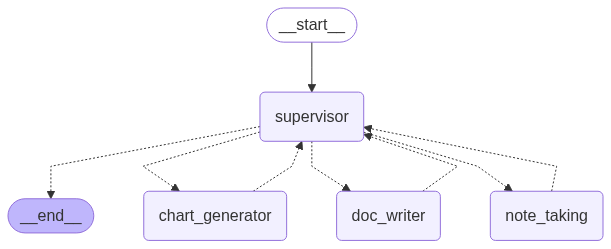

In [38]:
from IPython.display import display,Image
display(Image(paper_writing_builder.get_graph().draw_mermaid_png()))

In [39]:
for s in paper_writing_builder.stream(
    {
        "messages":[
            (
                "user",
                "Write an outline for poem about cats and then write the poem to the disk"
            )
        ]
    },
    {"recursion_limit":25}
):
    print(s)
    print("----")

{'supervisor': {'next': 'doc_writer'}}
----
{'doc_writer': {'messages': [HumanMessage(content="It appears I'm unable to save the document at the moment due to a recurrent issue. I apologize for the inconvenience. You may want to try saving the poem manually on your device:\n\n```\nTitle: Ode to the Feline\n\nIntroduction  \nIn a sunlit corner, a cat lies in repose,  \nFur aglow with golden strokes of light,  \nWhiskers twitching, eyes gently closed,  \nA creature of elegance and delight.  \n\nDaily Life  \nCuriosity leads you to every nook,  \nPaws silent on the wandering path,  \nA sudden leap, a whirl, a playful glance,  \nChasing shadows in your static dance.  \nGroomed with care, you pause and rest,  \nIn the heart of peace, you've built your nest.\n\nNighttime  \nUnder the moon's gentle watch, you prowl,  \nA silent hunter in the midnight's shroud,  \nSoft paws trace the secret paths of night,  \nGuided by stars, ever alert and bright.\n\nThe Mystery of Cats  \nWhat whispers lie w

In [40]:
from langchain_core.messages import BaseMessage

llm = ChatOpenAI(model="gpt-4o")


In [50]:
def call_research_team(state:State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages":state["messages"][-1] } )
    return Command(
        update={
            "messages":[
                HumanMessage(content=response["messages"][-1].content, name="research_team")
            ]
        },
        goto ="supervisor"
    )


def call_paper_writing_team(state:State) -> Command[Literal["supervisor"]]:
    response = paper_writing_builder.invoke({"messages":state["messages"][-1] } )
    return Command(
        update={
            "messages":[
                HumanMessage(content=response["messages"][-1].content, name="writing_team")
            ]
        },
        goto ="supervisor"
    )
    
teams_supervisor_node = make_supervisor_node(llm, ["research_team","writing_team"])

In [51]:
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START,"supervisor")
super_graph = super_builder.compile()

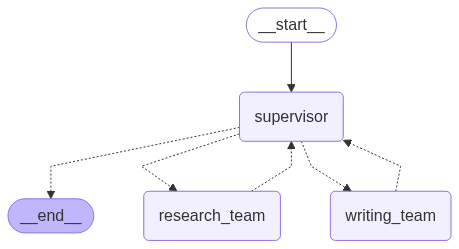

In [52]:
from IPython.display import display,Image
display(Image(super_graph.get_graph().draw_mermaid_png()))

In [53]:
for s in super_graph.stream(
    {
        "messages":[
            (
                "user",
                "What is RAG, check answer from the article from following link : https://medium.com/@tejpal.abhyuday/retrieval-augmented-generation-rag-from-basics-to-advanced-a2b068fd576c, and then generate outline and save the result"
            )
        ]
    },
    {"recursion_limit":50}
):
    print(s)
    print("----")

{'supervisor': {'next': 'research_team'}}
----
{'research_team': {'messages': [HumanMessage(content='### What is Retrieval-Augmented Generation (RAG)?\n\nRetrieval-Augmented Generation (RAG) is an AI framework designed to enhance the capabilities of Large Language Models (LLMs) by retrieving pertinent information from external sources before generating responses. This approach aids in grounding the LLMs on the most accurate information, thereby improving the quality and context-awareness of the responses provided to users.\n\n### Outline of the Article "Retrieval-Augmented Generation (RAG) from Basics to Advanced"\n\n#### 1. Introduction\n   - Introduction to retrieval-augmented generation and its significance in LLMs.\n   - Overview of alternative approaches and challenges solved by RAG.\n\n#### 2. RAG Structure and Process\n   - Explanation of the RAG pipeline.\n   - Step-by-step process of how RAG leverages databases for augmenting data in LLMs.\n   \n#### 3. Capabilities and Advant